In [1]:
# Informer approach (for time-series forecasting ..and adaptable for classification tasks)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim

In [7]:

# Load and preprocess data
file_path = 'creditcard.csv'  # Update this path to your file's location
data = pd.read_csv(file_path)

X = data.drop('Class', axis=1)

# Feature Engineering
tot_seconds = X['Time']
X['sin_tot_seconds'] = np.sin(2 * np.pi * tot_seconds / (24 * 60 * 60))
X['cos_tot_seconds'] = np.cos(2 * np.pi * tot_seconds / (24 * 60 * 60))
X = X.drop('Time', axis=1)
amount_pt = PowerTransformer(method='box-cox')
X['Amount'] = amount_pt.fit_transform(X[['Amount']] + 1e-9)
# X['Extra'] = 0  # Extra feature for input dimension compatibility

y = data['Class']

# Data Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=422, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:

class ProbSparseAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, top_k):
        super(ProbSparseAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.top_k = top_k

        self.query_layer = nn.Linear(embed_dim, embed_dim)
        self.key_layer = nn.Linear(embed_dim, embed_dim)
        self.value_layer = nn.Linear(embed_dim, embed_dim)
        self.out_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, L, _ = x.size()  # Batch size, Sequence length, Embedding dimension

        # Linear transformation
        Q = self.query_layer(x)
        K = self.key_layer(x)
        V = self.value_layer(x)

        # Calculate top_k dynamically based on sequence length
        current_top_k = min(self.top_k, L)

        if current_top_k <= 0:
            raise ValueError("top_k must be greater than 0")

        # Get mean of queries to determine importance
        Q_mean = Q.mean(dim=-1)

        # Select top_k indices based on mean values
        top_k_indices = Q_mean.topk(current_top_k, dim=1)[1]

        # Apply sparse attention using top_k indices
        sparse_Q = torch.gather(Q, 1, top_k_indices.unsqueeze(-1).expand(-1, -1, Q.size(-1)))
        sparse_K = torch.gather(K, 1, top_k_indices.unsqueeze(-1).expand(-1, -1, K.size(-1)))
        sparse_V = torch.gather(V, 1, top_k_indices.unsqueeze(-1).expand(-1, -1, V.size(-1)))

        # Compute attention with the reduced set of queries and keys
        attn_scores = torch.matmul(sparse_Q, sparse_K.transpose(-2, -1)) / np.sqrt(self.embed_dim)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, sparse_V)

        # Output projection
        output = self.out_layer(attn_output)

        # Return both the output and the attention weights for visualization
        return output, attn_weights

In [9]:

class InformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, top_k, num_classes):
        super(InformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.encoder = nn.Linear(input_dim, embed_dim)
        self.attention = ProbSparseAttention(embed_dim, num_heads, top_k)
        self.decoder = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x, attn_weights = self.attention(x)
        x = self.decoder(x)
        return torch.sigmoid(x).squeeze(), attn_weights

# Initialize the Informer Model
model = InformerModel(input_dim=X_train.shape[1], embed_dim=128, num_heads=8, top_k=5, num_classes=1)

# Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(1)
        optimizer.zero_grad()
        outputs, _ = model(X_batch)  # We don't need attention scores here
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/1, Loss: 0.0015


No attention weights were captured during evaluation.
Test Accuracy: 0.9993
Precision: 0.7810
Recall (TPR): 0.8367
TNR: 0.9996
F1 Score: 0.8079
ROC AUC: 0.9528


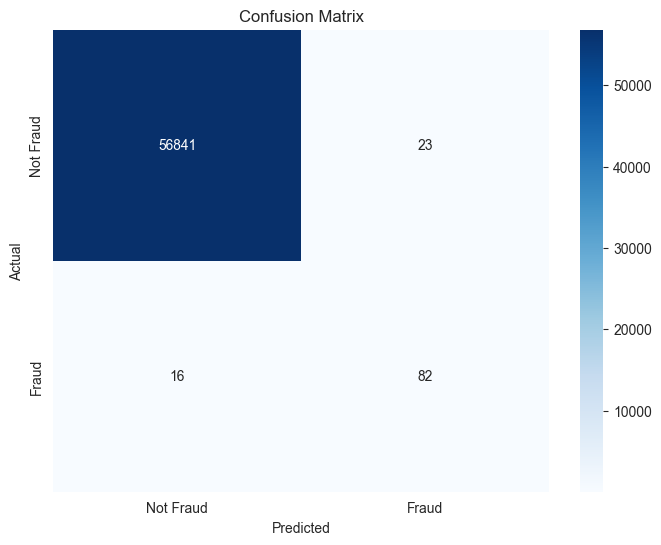

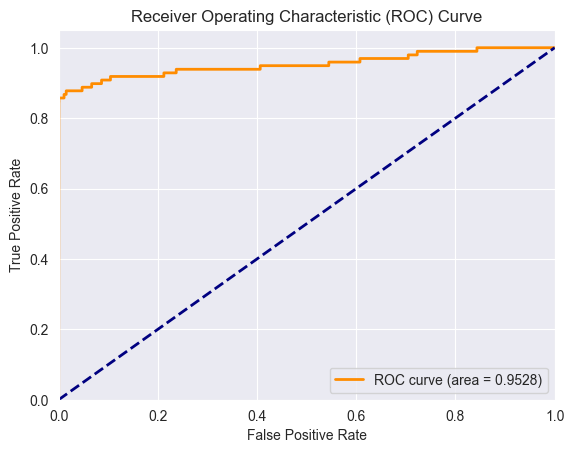

In [10]:

# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []
attn_weights_all = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(1)
        outputs, attn_weights = model(X_batch)  # Extract attention scores here
        probs = outputs
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.tolist())
        all_labels.extend(y_batch.tolist())
        all_probs.extend(probs.tolist())
        attn_weights_all.append(attn_weights.cpu().numpy())  # Save attention weights for plotting

# Attention weights could have varying shapes, so handle them accordingly
# if len(attn_weights_all) > 0:
if False:
    # Only take the first batch's attention weights for visualization
    attn_weights_first_batch = attn_weights_all[0]

    # Print attention weights
    print("Attention Weights (First Batch, First Query):")
    print(attn_weights_first_batch[0])

    # Check attention weights shape
    print(f"Shape of attn_weights_first_batch: {attn_weights_first_batch.shape}")

    # Plot Sparsity in Attention Mechanism for the first batch
    plt.figure(figsize=(10, 6))
    sns.heatmap(attn_weights_first_batch[0, :, :], cmap='coolwarm', cbar=True, annot=True, fmt=".2f",
                norm=plt.Normalize(0, np.max(attn_weights_first_batch[0, :, :])))  # Visualize attention weights with a different color scale
    plt.title('Attention Weights Visualization')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.show()
else:
    print("No attention weights were captured during evaluation.")

# Metrics Calculation
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)
tpr = recall
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
tnr = tn / (tn + fp)

# Print Metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (TPR): {tpr:.4f}')
print(f'TNR: {tnr:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve Plot
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
